In [60]:
# allow for interactive plots in vscode
%matplotlib widget

import soundfile as sf
import numpy as np
import struct
import binascii
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import struct
import scipy as sp
import pandas as pd

# Note: libopus is required for this to work, use available on conda-forge for windows
import opuslib

In [61]:
file_name = 'Test_log_aud_BLE.txt'

out_bytes_all = b''

with open(file_name, "rb") as f:
    for line in f:
        splitted = line.split(b"\t")
        
        if len(splitted) >= 3:
            part = splitted[2]

            if part[1:4] == b"(0x":
                data = part.split()[1][:-1]
                hex_data = str(data.strip())
                hex_data = hex_data[2:-1]
                # print(hex_dbg.replace("-", "").split())
                hex_data = hex_data.replace("-", "")
                byte_data = bytes.fromhex(hex_data)

                out_bytes_all += byte_data

with open("reformatted_bytes.txt", "wb") as outfile:
    outfile.write(out_bytes_all)

file_name = "reformatted_bytes.txt"

In [62]:
header_bno = b'\xcc\xcc'
last_idx_bno = -1

# Create lists to store indexes
idx_list_bno = []

# Accel lists
x_list_bno = []
y_list_bno = []
z_list_bno = []

yaw_list_bno = []
pitch_list_bno = []
roll_list_bno = []

time_list_bno = []

header_t5838 = b'\xaa\xaa'
last_idx_t5838 = -1
pcm_data_t5838 = []
time_list_t5838 = []
idx_list_t5838 = []

In [63]:
n_bno_frames = 0

with open(file_name, "rb") as f:
    while True:

        head = f.read(2)

        if head == b'':
            break

        # if(head != header_bno and head != header_t5838):
        #     # print("Header not found...")
        #     continue
        
        if head == header_bno:
            n_bno_frames += 1
            seconds = int.from_bytes(f.read(4), "little")
            millisec = int.from_bytes(f.read(2), "little")
            timestamp = seconds + millisec / 1000.0
            len_ = int.from_bytes(f.read(1), "little")
            for i in range(10):
                idx = int.from_bytes(f.read(1), "little")

                # Check if index is valid
                if((last_idx_bno+1)%256 != idx and last_idx_bno > 0):
                    print("error idx bno")
                    print(idx)
                    print(f.tell())
                
                last_idx_bno = idx
                idx_list_bno.append(idx)  # Append index to list
                time_list_bno.append(timestamp-0.09+0.01*i)
                yaw = int.from_bytes(f.read(2), "little", signed=True)
                pitch = int.from_bytes(f.read(2), "little", signed=True)
                roll = int.from_bytes(f.read(2), "little", signed=True)
                x_accel = int.from_bytes(f.read(2), "little", signed=True)
                y_accel = int.from_bytes(f.read(2), "little", signed=True)
                z_accel = int.from_bytes(f.read(2), "little", signed=True)
                x_list_bno.append(x_accel)
                y_list_bno.append(y_accel)
                z_list_bno.append(z_accel)
                yaw_list_bno.append(yaw)
                pitch_list_bno.append(pitch)
                roll_list_bno.append(roll)
        
        
        if head == header_t5838:
            seconds = int.from_bytes(f.read(4), "little")
            millisec = int.from_bytes(f.read(2), "little")
            timestamp = seconds + millisec / 1000.0
            len_ = int.from_bytes(f.read(1), "little")
            idx = int.from_bytes(f.read(1), "little")

            # Check if index is valid
            if((last_idx_t5838+1)%256 != idx and last_idx_t5838 > 0):
                print("error idx t5838")
                print(idx)
                print(f.tell())

            last_idx_t5838 = idx
            idx_list_t5838.append(idx)
            time_list_t5838.append(timestamp)
            frame = f.read(len_-1-6)

            pcm_data_t5838.append(frame)

print()
print(n_bno_frames)


error idx t5838
201
54920
error idx bno
96
55408

60


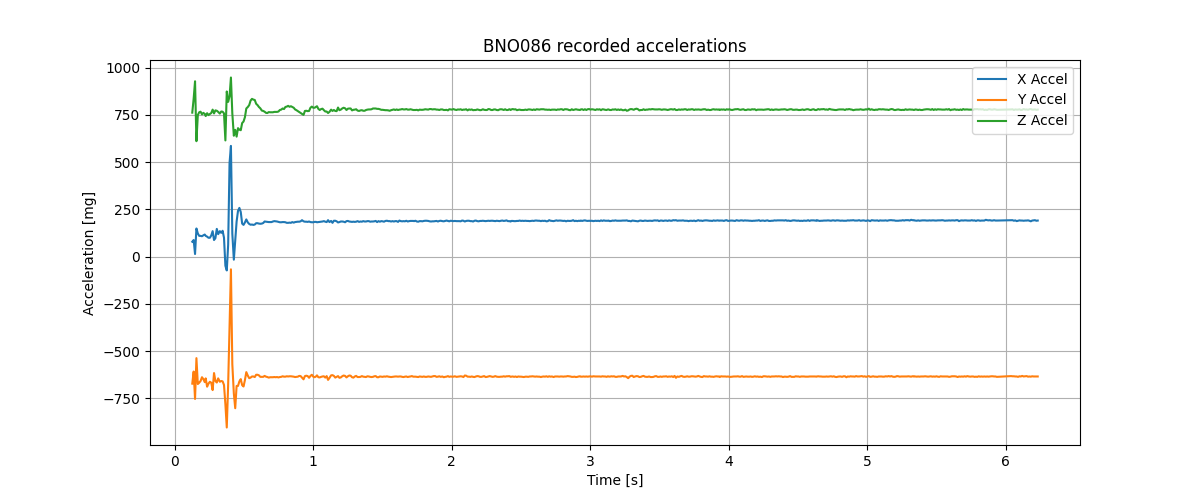

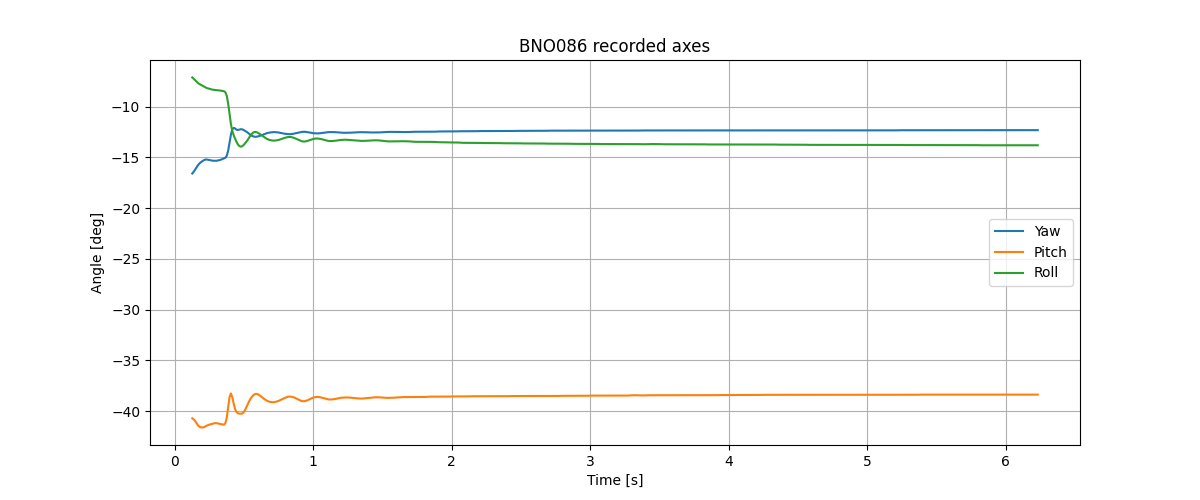

In [64]:
## Plot BNO086 data

# Create a new figure
plt.figure(figsize=(12, 5))

# Plot x acceleration
plt.plot(time_list_bno, x_list_bno, label='X Accel')

# Plot y acceleration
plt.plot(time_list_bno, y_list_bno, label='Y Accel')

# Plot z acceleration
plt.plot(time_list_bno, z_list_bno, label='Z Accel')

# Add a legend
plt.legend()

plt.title("BNO086 recorded accelerations")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [mg]")

plt.grid()

plt.ion()

# Show the plot
plt.show()


# Create a new figure
plt.figure(figsize=(12, 5))

# Plot x acceleration
plt.plot(time_list_bno, np.array(yaw_list_bno)/100, label='Yaw')

# Plot y acceleration
plt.plot(time_list_bno, np.array(pitch_list_bno)/100, label='Pitch')

# Plot z acceleration
plt.plot(time_list_bno, np.array(roll_list_bno)/100, label='Roll')

# Add a legend
plt.legend()

plt.title("BNO086 recorded axes")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")

plt.grid()

plt.ion()

# Show the plot
plt.show()

23400
8000
23400
2.925


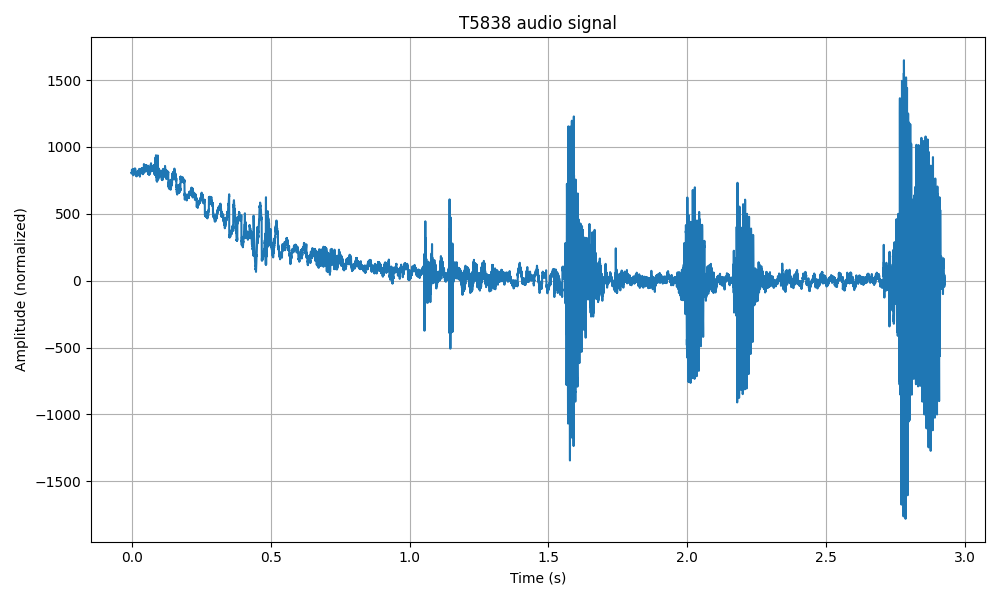

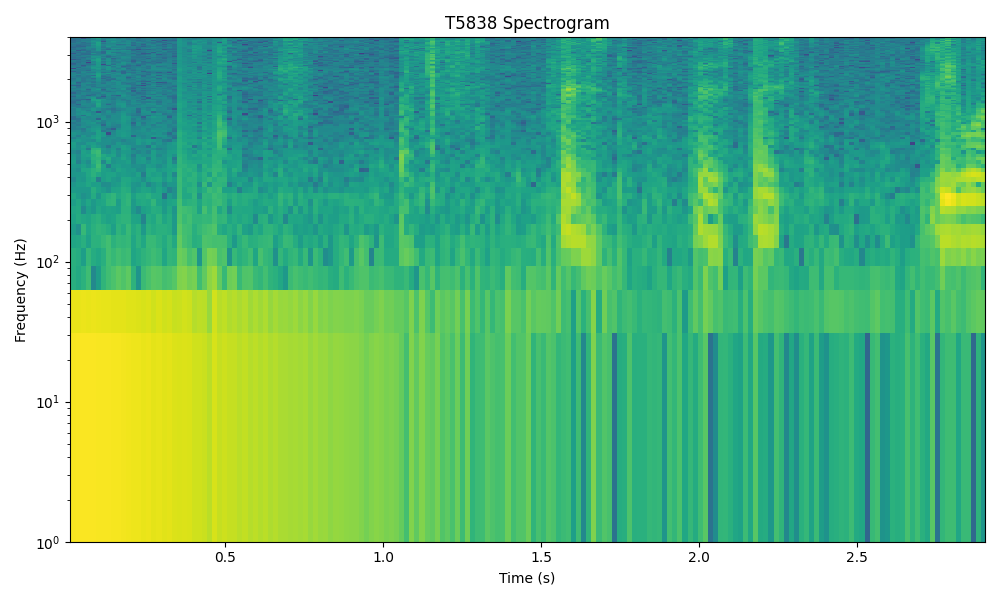

In [65]:
## Plot T5838 data

pcm_data_bytes = b''.join(pcm_data_t5838)
pcm_array = np.frombuffer(pcm_data_bytes, dtype=np.int16)
pcm_array = pcm_array * 2
print(np.size(pcm_array))

# FREQ = 12000
FREQ = 8000

sf.write('output_BLE.wav', pcm_array, FREQ)

sample_rate_micro, data_micro = wavfile.read('output_BLE.wav')
print(sample_rate_micro)
print(len(data_micro))
print((len(data_micro) / sample_rate_micro))

# Select one channel for stereo audio
if data_micro.ndim > 1:
    data_micro = data_micro[:, 0]

# max_freq = 6000
max_freq = 4000

plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(data_micro)) / sample_rate_micro, data_micro)
plt.title('T5838 audio signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.grid()

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))

plt.specgram(data_micro, Fs=sample_rate_micro)
plt.title('T5838 Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(1, max_freq)  # avoid log(0)
plt.yscale('log')

plt.tight_layout()
plt.show()